In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pickle
import json
import torch

from PIL import Image
from matplotlib import patches
from pathlib import Path
from tqdm.autonotebook import tqdm
from typing import Dict, List, Tuple

from extract_features import get_all_annotations

/tmp/ipykernel_3360312/2517684002.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [3]:
dataset_file = '/data/patho/Astma/cells_df.csv'
img_dir = '/data/patho/Astma/'
figure_dir = Path('figures/')
result_dir = Path('results/')
feature_dir = Path('/data/jonas/astma/features')

In [4]:
import utils.constants as constants
from utils.dataset_adaptors import load_astma_df

# load data 
_, test_dataset, lookups = load_astma_df(dataset_file)

# filter test samples 

# create test codes
test_codes = {0: 'None'}

# get test samples and labels
test_samples = get_all_annotations(
    dataset=test_dataset, 
    img_dir_path=img_dir, 
    domain_col='None',
    box_format='xyxy'
    )

# testset labels
test_annos = torch.tensor([v for l in test_samples.values() for v in l['labels']])
if 'midog' in dataset_file.lower():
    test_annos -= 1

In [5]:
from utils.factory import ConfigCreator, ModelFactory
from utils.inference import Yolov7_Inference, ImageProcessor
import pprint

config_file = 'optimized_models/yolov7_astma_bs_0.yaml'
iou_thres_1 = 0.7
iou_thres_2 = 0.3
augment = False
patch_size = 640
batch_size = 16
overlap = 0.3
device = 'cuda:0'
num_workers = 8
verbose = True
wsi = True


print('Initializing model ...', end=' ')
# load model config
config_file = ConfigCreator.load(config_file)

# load model 
model = ModelFactory.load(config_file)
print('Done.')

print('Loaded model configurations:')
pprint.pprint(config_file)
print()


# set up inference strategy
strategy = Yolov7_Inference(
    model=model, 
    conf_thres=config_file.det_thresh,
    iou_thres_1=iou_thres_1,
    iou_thres_2=iou_thres_2,
    augment=augment,
    )

# set up image processor
settings = {
    'batch_size': batch_size,
    'patch_size': patch_size,
    'overlap': overlap,
    'device': device,
    'num_workers': num_workers,
    'verbose': verbose,
    'wsi': wsi
}

# create processor
processor = ImageProcessor(strategy=strategy, **settings)
print('Loaded inference configurations:')
pprint.pprint(settings)
print()

INFO:models.yolo:
                 from  n    params  module                                  arguments                     
INFO:models.yolo:  0                -1  1       928  models.common.Conv                      [3, 32, 3, 1]                 
INFO:models.yolo:  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
INFO:models.yolo:  2                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
INFO:models.yolo:  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
INFO:models.yolo:  4                -1  1      8320  models.common.Conv                      [128, 64, 1, 1]               
INFO:models.yolo:  5                -2  1      8320  models.common.Conv                      [128, 64, 1, 1]               
INFO:models.yolo:  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
INFO:mo

INFO:models.yolo: 32                -1  1    590336  models.common.Conv                      [256, 256, 3, 1]              
INFO:models.yolo: 33                -1  1    590336  models.common.Conv                      [256, 256, 3, 1]              
INFO:models.yolo: 34                -1  1    590336  models.common.Conv                      [256, 256, 3, 1]              
INFO:models.yolo: 35                -1  1    590336  models.common.Conv                      [256, 256, 3, 1]              
INFO:models.yolo: 36  [-1, -3, -5, -6]  1         0  models.common.Concat                    [1]                           
INFO:models.yolo: 37                -1  1   1050624  models.common.Conv                      [1024, 1024, 1, 1]            
INFO:models.yolo: 38                -1  1         0  models.common.MP                        []                            
INFO:models.yolo: 39                -1  1    525312  models.common.Conv                      [1024, 512, 1, 1]             
INFO:mod

Initializing model ... 

/home/ammeling/projects/yolov7/env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:utils.torch_utils:Model Summary: 415 layers, 37272072 parameters, 37272072 gradients, 105.4 GFLOPS
INFO:models.yolo:
/home/ammeling/projects/yolov7/utils/factory.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unp

Done.
Loaded model configurations:
Yolov7_Config(model_name='yolov7_astma_bs_0',
              detector='yolov7',
              num_classes=7,
              cfg='cfg/training/yolov7-astma.yaml',
              weights='runs/train/yolov7_astma_bs_0/weights/best.pt',
              det_thresh=0.416)

Loaded inference configurations:
{'batch_size': 16,
 'device': 'cuda:0',
 'num_workers': 8,
 'overlap': 0.3,
 'patch_size': 640,
 'verbose': True,
 'wsi': True}



In [6]:
# collect filenames
filenames = test_dataset.filename.unique()

# init preds
preds = {}

# loop over files
for file in tqdm(filenames, desc='Collecting predictions'):
    
    # get image file location
    image = os.path.join(img_dir, file)

    # compute predictions
    res = processor.process_image(image)

    # extract results
    boxes = res['boxes']
    scores = res['scores']
    labels = res['labels']

    # collect predictions
    if boxes.shape[0] > 0:
        preds[file] = {'boxes': boxes, 'scores': scores, 'labels': labels}
    else:
        continue 

Processing image:   0%|          | 0/133 [00:00<?, ?it/s]

In [7]:
test_dataset.head()

,id,type,image,xmin,ymin,xmax,ymax,label,filename,class_names
45998,100794,1,222,14253,1973,14335,2055,2,BAL AIA Blickfang Luft.svs,Makrophagen
45999,100795,1,222,10463,3139,10567,3243,2,BAL AIA Blickfang Luft.svs,Makrophagen
46000,100796,1,222,10562,3058,10656,3152,2,BAL AIA Blickfang Luft.svs,Makrophagen
46002,100798,1,222,11028,3181,11116,3269,2,BAL AIA Blickfang Luft.svs,Makrophagen
46003,100799,1,222,11312,3142,11410,3240,2,BAL AIA Blickfang Luft.svs,Makrophagen


In [8]:
from utils.metrics import ConfusionMatrix

nc = 7

cm = ConfusionMatrix(nc, conf=config_file.det_thresh, iou_thres=iou_thres_2)


for file in filenames:

    labels = torch.tensor(
        test_dataset.query('filename == @file')[['label', 'xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        )

    results = preds[file]
    detections = torch.cat(
        [
            torch.tensor(results['boxes']),
            torch.tensor(results['scores'][..., None]),
            torch.tensor(results['labels'][..., None])                    
        ], 
        dim=1
    )



    cm.process_batch(detections, labels)

In [12]:
cm.matrix

array([[        833,          32,          11,           0,           2,           0,           0,          28],
       [         14,        9236,         609,           0,           0,           0,          48,         153],
       [          5,          54,       16186,          50,           3,           1,           0,         226],
       [          0,           0,         119,          27,           0,           0,           0,           2],
       [          5,          28,          12,           4,         491,           1,           0,          10],
       [          0,           3,           0,           0,           6,          33,           0,           0],
       [          0,           0,           0,           0,           0,           0,           0,          27],
       [         73,         435,         449,           6,         221,           6,           0,           0]])

In [13]:
import seaborn as sn 

m = cm.matrix
names = list(lookups['class_id_to_label'].values())


array = m / (m.sum(0).reshape(1, nc + 1) + 1E-6)  # normalize
array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

fig = plt.figure(figsize=(12, 9), tight_layout=True)
sn.set(font_scale=1.0 if nc < 50 else 0.8)  # for label size
labels = (0 < len(names) < 99) and len(names) == nc  # apply names to ticklabels
sn.heatmap(array, annot=nc < 30, annot_kws={"size": 8}, cmap='Blues', fmt='.2f', square=True,
            xticklabels=names + ['background FP'] if labels else "auto",
            yticklabels=names + ['background FN'] if labels else "auto").set_facecolor((1, 1, 1))
fig.axes[0].set_xlabel('True')
fig.axes[0].set_ylabel('Predicted')
fig.show()

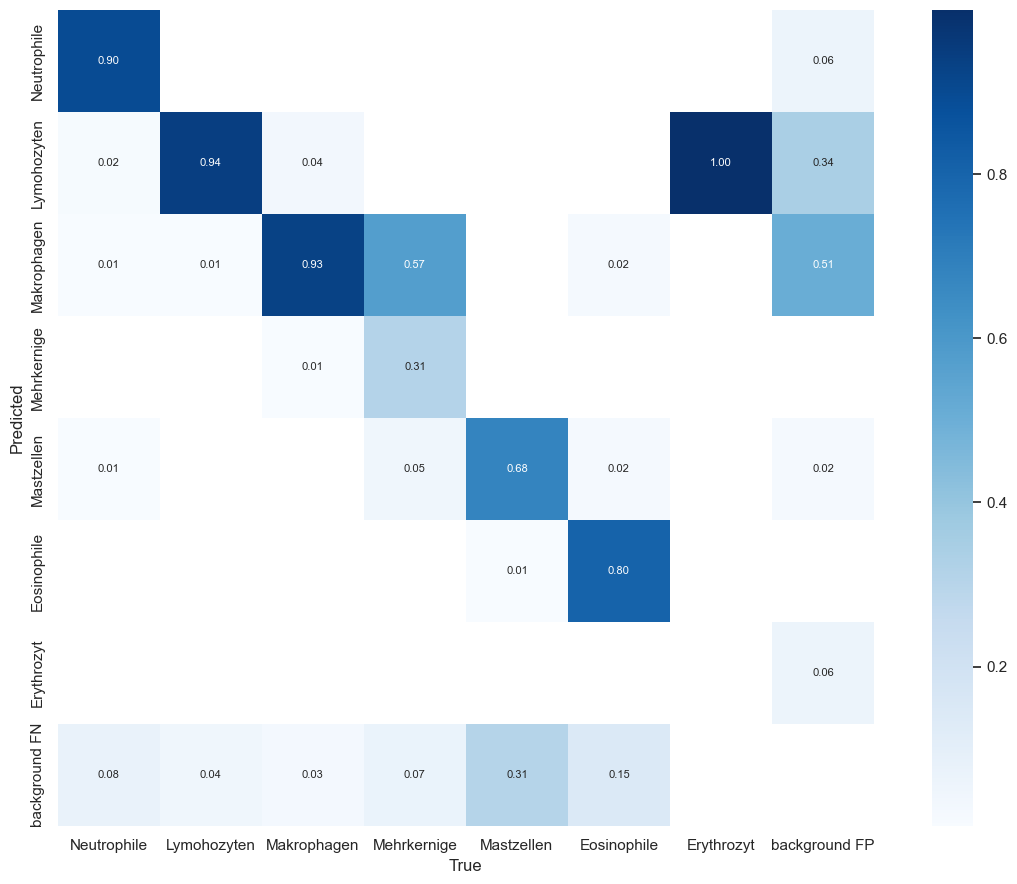

In [14]:
fig